In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pyasn
from iso3166 import countries

In [2]:
from numpy.random import uniform, normal, poisson, binomial
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf 
import statsmodels.api as sm

# DATA PREPARATION

### Abuse report data

In [3]:
data = pd.read_csv("merge_result.csv")
data

,Unnamed: 0,id,dateadded,url,url_status,threat,tags,urlhaus_link,reporter,AS_Number
0,0,544165,9/17/2020 10:10,http://115.98.1.103:56034/Mozi.a,offline,malware_download,None,https://urlhaus.abuse.ch/url/544165/,lrz_security,17488
1,1,544163,9/17/2020 10:10,http://115.97.82.185:47119/Mozi.m,online,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/544163/,lrz_security,17488
2,2,544164,9/17/2020 10:10,http://115.97.83.180:58110/Mozi.m,online,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/544164/,lrz_security,17488
3,3,544162,9/17/2020 10:10,http://115.98.145.51:60363/Mozi.m,online,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/544162/,lrz_security,17488
4,4,544161,9/17/2020 10:10,http://115.97.80.186:42284/Mozi.m,online,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/544161/,lrz_security,17488
...,...,...,...,...,...,...,...,...,...,...
108757,108757,435287,8/18/2020 0:04,http://14.157.58.114:35300/Mozi.m,offline,malware_download,Mozi,https://urlhaus.abuse.ch/url/435287/,Gandylyan1,4134
108758,108758,435286,8/18/2020 0:04,http://180.106.132.202:53524/Mozi.m,offline,malware_download,Mozi,https://urlhaus.abuse.ch/url/435286/,Gandylyan1,4134
108759,108759,435285,8/18/2020 0:04,http://36.105.58.7:38745/Mozi.m,offline,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/435285/,lrz_security,4134
108760,108760,435284,8/18/2020 0:03,http://johnsonlam.com/download/available_2mrDR...,online,malware_download,"doc,emotet,epoch1,heodo",https://urlhaus.abuse.ch/url/435284/,Cryptolaemus1,46015


### Reaction time per country data

In [4]:
react_time = pd.read_csv("reactspeedURLhaus_inminutes.csv")
react_time.head()

,rank,AS_Number,Name,Country,Online,Offline,months,days,hours,minutes,total_in_minutes
0,1,52715,SCORPION TELECOMUNICACAO RIBEIRAO PR ...,BR,0,1,0,0,0,3,3
1,2,13022,STREAMS_GMBH,AT,0,1,0,0,0,5,5
2,3,22438,CLEAR-RATE-COMMUNICATIONS,US,0,1,0,0,0,7,7
3,4,137344,IDNIC-TRANSTEKNO-AS-ID PT. TRANS NAS ...,ID,0,1,0,0,0,7,7
4,5,17716,NTU-TW National Taiwan University,TW,0,1,0,0,0,8,8


## Number of malware URLs per country

In [5]:
react_time['URL count'] = react_time['Online'] + react_time['Offline']
react_time.head()

,rank,AS_Number,Name,Country,Online,Offline,months,days,hours,minutes,total_in_minutes,URL count
0,1,52715,SCORPION TELECOMUNICACAO RIBEIRAO PR ...,BR,0,1,0,0,0,3,3,1
1,2,13022,STREAMS_GMBH,AT,0,1,0,0,0,5,5,1
2,3,22438,CLEAR-RATE-COMMUNICATIONS,US,0,1,0,0,0,7,7,1
3,4,137344,IDNIC-TRANSTEKNO-AS-ID PT. TRANS NAS ...,ID,0,1,0,0,0,7,7,1
4,5,17716,NTU-TW National Taiwan University,TW,0,1,0,0,0,8,8,1


In [6]:
url_count=react_time.groupby('Country').sum()['URL count'].to_frame()
url_count.columns=['URL count']
url_count=url_count.reset_index()
url_count.sort_values('URL count', ascending=False)

,Country,URL count
146,US,155472
64,IN,86436
30,CN,40651
38,DE,18656
124,RU,16896
...,...,...
59,HT,1
69,JM,1
155,YE,1
127,SD,1


## Average reaction time per country

In [7]:
time_median=react_time.groupby('Country').median()['total_in_minutes'].to_frame()
time_median.columns = ['Reaction time median']
time_median=time_median.reset_index()
time_median.head()

,Country,Reaction time median
0,AE,16110.5
1,AL,5819.0
2,AM,108223.0
3,AR,5960.0
4,AT,5403.0


## IP space

In [8]:
asndb = pyasn.pyasn("ipasn_20150113.dat")

In [9]:
#dummy test to get AS prefixes
tes=asndb.get_as_prefixes(52715)
tes

{'177.84.20.0/22',
 '177.84.20.0/24',
 '177.84.21.0/24',
 '177.84.22.0/24',
 '177.84.23.0/24'}

In [10]:
#dummy test to get IP space per prefix 2^(32-/n)
for i in tes:
    print(2**(32-(int(i.split('/')[-1]))))

1024
256
256
256
256


In [11]:
#retreiving IP space for all ASNs
all_ip_space=[]

for row in range(len(react_time)):
    
    ip_space = 0
    asn = (react_time.iloc[row,1])
    
    if asn != 'None':
        
        prefixes = asndb.get_as_prefixes(asn)

        if prefixes is not None:
            for ip in prefixes:
                ip_space += 2**(32-(int(ip.split('/')[-1])))
            all_ip_space.append(ip_space)
        else:
            all_ip_space.append(0)
    else:
        all_ip_space.append(0)
        
len(all_ip_space)

4813

In [12]:
#merging the react time dataset with the IP space
react_time['IP space']=all_ip_space
react_time.head()

,rank,AS_Number,Name,Country,Online,Offline,months,days,hours,minutes,total_in_minutes,URL count,IP space
0,1,52715,SCORPION TELECOMUNICACAO RIBEIRAO PR ...,BR,0,1,0,0,0,3,3,1,2048
1,2,13022,STREAMS_GMBH,AT,0,1,0,0,0,5,5,1,6400
2,3,22438,CLEAR-RATE-COMMUNICATIONS,US,0,1,0,0,0,7,7,1,13312
3,4,137344,IDNIC-TRANSTEKNO-AS-ID PT. TRANS NAS ...,ID,0,1,0,0,0,7,7,1,0
4,5,17716,NTU-TW National Taiwan University,TW,0,1,0,0,0,8,8,1,76800


In [13]:
#summing the IP space per country
IP_space_ctr=react_time.groupby('Country').sum()['IP space'].to_frame().reset_index()
IP_space_ctr=IP_space_ctr.sort_values(by='IP space', ascending=False)
IP_space_ctr

,Country,IP space
146,US,494189994
30,CN,383767296
71,JP,172025584
38,DE,157256250
75,KR,116083784
...,...,...
34,CV,0
154,XK,0
155,YE,0
126,SC,0


In [14]:
#removing countries with 0 IP values, meaning missing data
IP_space_ctr=IP_space_ctr[IP_space_ctr['IP space']!=0]
IP_space_ctr

,Country,IP space
146,US,494189994
30,CN,383767296
71,JP,172025584
38,DE,157256250
75,KR,116083784
...,...,...
153,VU,14592
82,LR,10752
26,CG,6656
25,CD,4864


## Rule of Law Index

In [15]:
rol=pd.read_csv('Rule of Law Index.csv')
rol.head()

,Country Code,Rule of Law Index
0,AFG,0.36
1,ALB,0.50
2,DZA,0.49
3,AGO,0.43
4,ATG,0.63


In [16]:
#Converting the 3-letter-code country to 2-letter-code
Country=[]
for row in range(len(rol)):
    ctr=rol.iloc[row,0]
    ccode=countries.get(ctr).alpha2
    Country.append(ccode)
rol['Country']=Country
rol.head()

,Country Code,Rule of Law Index,Country
0,AFG,0.36,AF
1,ALB,0.50,AL
2,DZA,0.49,DZ
3,AGO,0.43,AO
4,ATG,0.63,AG


# MERGING OF DATA

In [17]:
#merging url count and reaction time
factor=pd.merge(url_count,time_median,on='Country',how='inner')
factor

,Country,URL count,Reaction time median
0,AE,16,16110.5
1,AL,38,5819.0
2,AM,17,108223.0
3,AR,531,5960.0
4,AT,177,5403.0
...,...,...,...
153,VU,4,36.0
154,XK,3389,24367.0
155,YE,1,587.0
156,ZA,988,5471.0


In [18]:
#merging with IP space
factor=pd.merge(factor,IP_space_ctr,on='Country',how='inner')
factor

,Country,URL count,Reaction time median,IP space
0,AE,16,16110.5,9214208
1,AL,38,5819.0,313600
2,AM,17,108223.0,614656
3,AR,531,5960.0,20933056
4,AT,177,5403.0,4106368
...,...,...,...,...
148,VI,1,571415.0,43520
149,VN,5159,21973.5,32344096
150,VU,4,36.0,14592
151,ZA,988,5471.0,30727112


In [19]:
#merging with rule of law
factor=pd.merge(factor,rol[['Country','Rule of Law Index']],on='Country',how='inner')
factor

,Country,URL count,Reaction time median,IP space,Rule of Law Index
0,AE,16,16110.5,9214208,0.65
1,AL,38,5819.0,313600,0.50
2,AR,531,5960.0,20933056,0.58
3,AT,177,5403.0,4106368,0.82
4,AU,1225,10786.0,34648755,0.80
...,...,...,...,...,...
103,UZ,143,19752.0,92928,0.47
104,VE,73,46326.5,4650752,0.27
105,VN,5159,21973.5,32344096,0.49
106,ZA,988,5471.0,30727112,0.59


In [20]:
#transforming the skewed data with log-transformations
factor['Reaction speed']=1440/factor['Reaction time median']
factor

,Country,URL count,Reaction time median,IP space,Rule of Law Index,Reaction speed
0,AE,16,16110.5,9214208,0.65,0.089383
1,AL,38,5819.0,313600,0.50,0.247465
2,AR,531,5960.0,20933056,0.58,0.241611
3,AT,177,5403.0,4106368,0.82,0.266519
4,AU,1225,10786.0,34648755,0.80,0.133506
...,...,...,...,...,...,...
103,UZ,143,19752.0,92928,0.47,0.072904
104,VE,73,46326.5,4650752,0.27,0.031084
105,VN,5159,21973.5,32344096,0.49,0.065533
106,ZA,988,5471.0,30727112,0.59,0.263206


Checking the skewness of data. Use log transformation for highliy skewed data (following Tajalizadehkhoob)

Text(0, 0.5, 'Frequency')

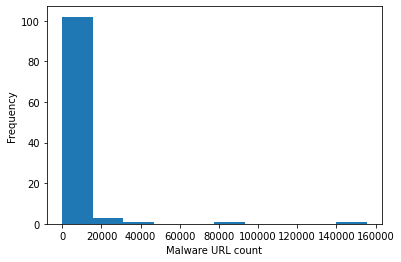

In [21]:
plt.hist(factor['URL count'])
plt.xlabel('Malware URL count')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

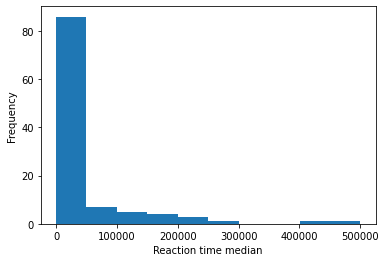

In [22]:
plt.hist(factor['Reaction time median'])
plt.xlabel('Reaction time median')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

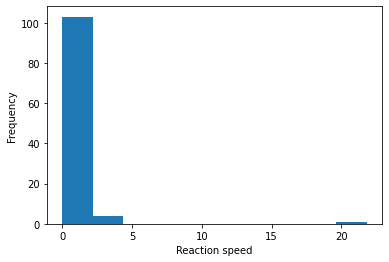

In [23]:
plt.hist(factor['Reaction speed'])
plt.xlabel('Reaction speed')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

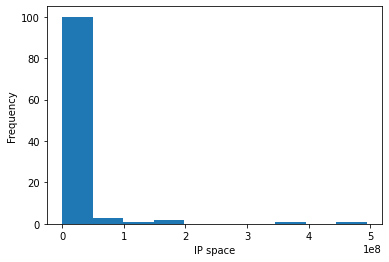

In [24]:
plt.hist(factor['IP space'])
plt.xlabel('IP space')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

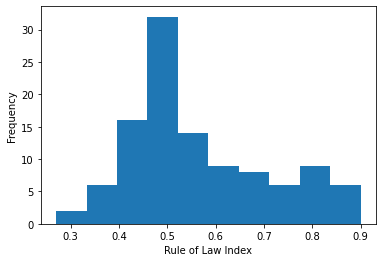

In [25]:
plt.hist(factor['Rule of Law Index'])
plt.xlabel('Rule of Law Index')
plt.ylabel('Frequency')

In [26]:
#transforming the skewed data with log-transformations
factor['log10(Reaction time median)']=np.log10(factor['Reaction time median'])
factor['log10(Reaction speed)']=np.log10(factor['Reaction speed'])
factor['log10(IP space)']=np.log10(factor['IP space'])
factor

,Country,URL count,Reaction time median,IP space,Rule of Law Index,Reaction speed,log10(Reaction time median),log10(Reaction speed),log10(IP space)
0,AE,16,16110.5,9214208,0.65,0.089383,4.207109,-1.048747,6.964458
1,AL,38,5819.0,313600,0.50,0.247465,3.764848,-0.606486,5.496376
2,AR,531,5960.0,20933056,0.58,0.241611,3.775246,-0.616884,7.320833
3,AT,177,5403.0,4106368,0.82,0.266519,3.732635,-0.574272,6.613458
4,AU,1225,10786.0,34648755,0.80,0.133506,4.032860,-0.874498,7.539688
...,...,...,...,...,...,...,...,...,...
103,UZ,143,19752.0,92928,0.47,0.072904,4.295611,-1.137249,4.968147
104,VE,73,46326.5,4650752,0.27,0.031084,4.665829,-1.507467,6.667523
105,VN,5159,21973.5,32344096,0.49,0.065533,4.341899,-1.183537,7.509795
106,ZA,988,5471.0,30727112,0.59,0.263206,3.738067,-0.579704,7.487522


Descriptive summary of the variables

In [27]:
desc=factor.describe()
desc.to_excel("desc.xlsx")  
desc

,URL count,Reaction time median,IP space,Rule of Law Index,Reaction speed,log10(Reaction time median),log10(Reaction speed),log10(IP space)
count,108.000000,108.000000,1.080000e+02,108.000000,108.000000,108.000000,108.000000,108.000000
mean,4012.537037,45687.199074,2.109507e+07,0.565000,0.479459,4.192154,-1.033792,6.274274
std,17541.138185,78826.293561,6.479453e+07,0.143067,2.156943,0.696905,0.696905,1.134591
min,1.000000,66.000000,3.072000e+03,0.270000,0.002879,1.819544,-2.540687,3.487421
25%,14.750000,5855.875000,2.401280e+05,0.470000,0.035946,3.767591,-1.444375,5.379792
50%,141.000000,15194.250000,2.713984e+06,0.520000,0.095114,4.180899,-1.022536,6.428664
75%,1465.000000,40064.250000,1.134614e+07,0.660000,0.245908,4.602737,-0.609229,7.054415
max,155472.000000,500092.000000,4.941900e+08,0.900000,21.818182,5.699050,1.338819,8.693894


# FACTOR ANALYSIS

In [28]:
#setting URL as the dependent variable y
y=factor[['URL count']]
y

,URL count
0,16
1,38
2,531
3,177
4,1225
...,...
103,143
104,73
105,5159
106,988


## Model 1: "Intercept"

In [29]:
def pseudor2(k):
    dev_model = res.deviance
    dispersion = res.scale
    
    pr2 = 1 - (dev_model + k * dispersion)/dev_intercept
    print('Explained Variance (Pseudo-R2) = ',pr2)

In [30]:
x=[0]*len(factor)

exog, endog = sm.add_constant(x), y

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())

y_pred = res.predict(exog)

dev_intercept=res.deviance

C:\Users\stell\Anaconda3\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\stell\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\stell\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\stell\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              URL count   No. Observations:                  108
Model:                            GLM   Df Residuals:                      107
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.8214e+05
Date:                Mon, 26 Oct 2020   Deviance:                   1.9635e+06
Time:                        10:00:37   Pearson chi2:                 8.21e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2972      0.002   5462.002      0.000       8.294       8.300
x1                  0          0        nan        nan           0           0
==============================================================================
"""

## Model 2: "IP Space"

In [31]:
x=factor[['log10(IP space)']]

exog, endog = sm.add_constant(x), y

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())

y_pred = res.predict(exog)

pseudor2(k=1)

C:\Users\stell\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              URL count   No. Observations:                  108
Model:                            GLM   Df Residuals:                      106
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1230e+05
Date:                Mon, 26 Oct 2020   Deviance:                   6.2387e+05
Time:                        10:00:37   Pearson chi2:                 1.47e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -7.7232      0.019   -414.205      0.000      -7.760      -7.687
log10(IP space)     2.1973      0.002    945.231      0.000       2.193       2.202
===================================================================================
"""

Explained Variance (Pseudo-R2) =  0.682274492006942


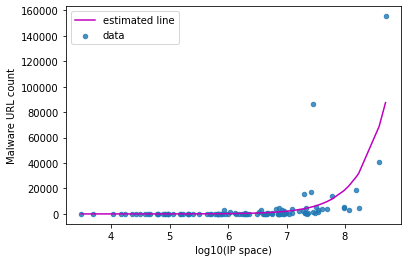

In [32]:
y_pred=y_pred.to_frame()

idx=pd.Index(x['log10(IP space)'])
order=idx.argsort()
x_ord=x.reindex(order)
y_pred_ord=y_pred.reindex(order)

plt.plot(x_ord, y_pred_ord, color='m',label='estimated line')
plt.scatter(x['log10(IP space)'], y,  s=20, alpha=0.8,label='data')
plt.xlabel("log10(IP space)")
plt.ylabel("Malware URL count")
plt.legend(loc=0)

## Model 3: "IP space, Reaction speed"

In [33]:
x=factor[['log10(IP space)','log10(Reaction speed)']]

exog, endog = sm.add_constant(x), y

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())

y_pred = res.predict(exog)

pseudor2(k=2)

C:\Users\stell\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              URL count   No. Observations:                  108
Model:                            GLM   Df Residuals:                      105
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.7845e+05
Date:                Mon, 26 Oct 2020   Deviance:                   5.5616e+05
Time:                        10:00:37   Pearson chi2:                 9.59e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -8.8683      0.021   -418.851      0.000      -8.910      -8.827
log10(IP space)           2.4556      0.003    874.846      0.000       2.450       2.461
log10(Reaction speed)     1.0190      0.004    252.850      0.000       1.011       1.027
=========================================================================================
"""

Explained Variance (Pseudo-R2) =  0.7167564969376743


## Model 4: "IP Space", "Reaction speed ", "Rule of Law Index"

In [34]:
x=factor[['log10(IP space)','log10(Reaction speed)','Rule of Law Index']]

exog, endog = sm.add_constant(x), y

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())

y_pred = res.predict(exog)

pseudor2(k=3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              URL count   No. Observations:                  108
Model:                            GLM   Df Residuals:                      104
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.6157e+05
Date:                Mon, 26 Oct 2020   Deviance:                   5.2241e+05
Time:                        10:00:37   Pearson chi2:                 8.68e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -8.6936      0.022   -402.851      0.000      -8.736      -8.651
log10(IP space)           2.6316      0.003    856.882      0.000       2.626       2.638
log10(Reaction speed)     1.2002      0.004    308.084      0.000       1.193       1.208
Rule of Law Index        -2.1829      0.012   -183.585      0.000      -2.206      -2.160
=========================================================================================
"""

Explained Variance (Pseudo-R2) =  0.7339438249212296


# Testing intercorrelation between Rule of Law Index and Reaction speed

In [41]:
from scipy.stats import pearsonr 
corr, _ = pearsonr(factor['Rule of Law Index'],factor['log10(Reaction speed)'])
corr

0.2121683337392694

Text(0, 0.5, 'Reaction speed')

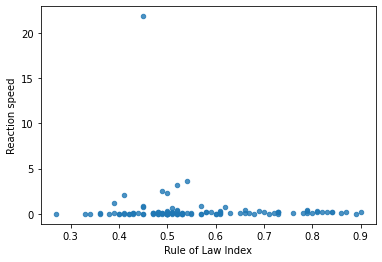

In [36]:
plt.scatter(factor['Rule of Law Index'], factor['Reaction speed'],  s=20, alpha=0.8,label='data')
plt.xlabel('Rule of Law Index')
plt.ylabel('Reaction speed')

In [42]:
corr, _ = pearsonr(factor['Rule of Law Index'],factor['log10(IP space)'])
corr

0.4739914446290188

In [43]:
corr, _ = pearsonr(factor['log10(Reaction speed)'],factor['log10(IP space)'])
corr

0.21222919034358678

# Principal Component Analysis

In [37]:
# Separating out the features
x = factor.loc[:, ['Reaction speed','Rule of Law Index']].values
# Separating out the target
y = factor.loc[:,['URL count']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)


In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1'])
principalDf

,principal component 1
0,-0.550543
1,0.246350
2,-0.152820
3,-1.336341
4,-1.280839
...,...
103,0.337823
104,1.317154
105,0.236085
106,-0.195362


In [39]:
pca.explained_variance_ratio_

array([0.54506747])

In [40]:
factor['PCA']=principalDf['principal component 1']
x=factor[['log10(IP space)','PCA']]

exog, endog = sm.add_constant(x), y

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())

y_pred = res.predict(exog)

pseudor2(k=1)

C:\Users\stell\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                            GLM   Df Residuals:                      105
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.0723e+05
Date:                Mon, 26 Oct 2020   Deviance:                   6.1372e+05
Time:                        10:00:38   Pearson chi2:                 1.32e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -7.9468      0.019   -429.191      0.000      -7.983      -7.910
log10(IP space)     2.2386      0.002    961.355      0.000       2.234       2.243
PCA                 0.2152      0.002    102.554      0.000       0.211       0.219
===================================================================================
"""

Explained Variance (Pseudo-R2) =  0.6874410710409589
